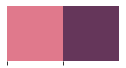

In [1]:
import gc
import random
import math
import time
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import seaborn as sns
# Set Color Palettes for the notebook
colors_nude = ['#e0798c','#65365a']
sns.palplot(sns.color_palette(colors_nude))
# Set Style
sns.despine(left=True, bottom=True)
#sns.set_style("whitegrid")
plt.style.use('fivethirtyeight')
import altair as alt

from sklearn.model_selection import train_test_split, StratifiedKFold, GroupKFold, KFold
from sklearn import metrics 
from sklearn import preprocessing
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler, RobustScaler


import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M


import warnings as wrn
wrn.filterwarnings('ignore', category = DeprecationWarning) 
wrn.filterwarnings('ignore', category = FutureWarning) 
wrn.filterwarnings('ignore', category = UserWarning) 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Read the data csv file
df = pd.read_csv('/content/drive/My Drive/musk_csv.csv')
df.head()

,ID,molecule_name,conformation_name,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,...,f128,f129,f130,f131,f132,f133,f134,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,class
0,1,MUSK-211,211_1+1,46,-108,-60,-69,-117,49,38,-161,-8,5,-323,-220,-113,-299,-283,-307,-31,-106,-227,-42,-59,-22,-67,189,81,17,-27,-89,-67,105,-116,124,-106,5,-120,63,-165,...,81,-114,-187,45,-118,-75,-182,-234,-19,12,-13,-41,-119,-149,70,17,-20,-177,-101,-116,-14,-50,24,-81,-125,-114,-44,128,3,-244,-308,52,-7,39,126,156,-50,-112,96,1
1,2,MUSK-211,211_1+10,41,-188,-145,22,-117,-6,57,-171,-39,-100,-319,-111,-228,-281,-281,-300,54,-149,-98,-196,-27,-22,2,75,49,-34,45,-91,32,95,-116,85,-23,42,-58,61,-171,...,88,-21,-32,32,-128,-72,-124,-218,-94,53,-79,-20,-35,-26,4,50,17,-177,-102,-121,-66,-77,51,-41,-34,-32,-63,115,-5,-235,-59,-2,52,103,136,169,-61,-136,79,1
2,3,MUSK-211,211_1+11,46,-194,-145,28,-117,73,57,-168,-39,-22,-319,-111,-104,-283,-282,-303,52,-152,-97,-225,-28,-22,2,179,49,-33,46,-88,22,79,-116,19,-11,6,-38,71,-175,...,64,0,-23,-15,-129,-74,-125,-221,-93,53,-72,-19,-33,-26,3,49,17,-177,-102,-119,-66,-81,51,-41,-27,-41,-140,77,-163,-238,-134,-154,57,143,142,165,-67,-145,39,1
3,4,MUSK-211,211_1+12,41,-188,-145,22,-117,-7,57,-170,-39,-99,-319,-111,-228,-282,-281,-301,54,-150,-98,-196,-28,-22,2,77,48,-34,46,-91,32,94,-116,84,-23,41,-58,62,-171,...,88,-20,-32,32,-128,-73,-125,-220,-93,53,-78,-19,-34,-26,4,50,17,-177,-101,-121,-65,-77,52,-41,-34,-32,-66,115,-7,-236,-60,-4,52,104,136,168,-60,-135,80,1
4,5,MUSK-211,211_1+13,41,-188,-145,22,-117,-7,57,-170,-39,-99,-319,-111,-228,-282,-281,-301,54,-150,-98,-196,-28,-22,2,78,48,-34,46,-91,31,94,-116,84,-23,41,-58,62,-171,...,88,-20,-32,32,-128,-73,-125,-220,-93,53,-78,-19,-34,-26,4,50,17,-177,-101,-121,-65,-76,52,-41,-34,-32,-66,115,-8,-236,-60,-4,52,104,137,168,-60,-135,80,1


## Check for the Missing Values

In [4]:
# variable description of missing dtypes and uniques values  
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    tt['Uniques'] = data.nunique().values
    return(np.transpose(tt))

In [5]:
%%time
print('Dimension of data:', df.shape)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(missing_data(df))

Dimension of data: (6598, 170)


,ID,molecule_name,conformation_name,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118,f119,f120,f121,f122,f123,f124,f125,f126,f127,f128,f129,f130,f131,f132,f133,f134,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,class
Total,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Types,int64,object,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
Uniques,6598,102,6598,202,260,221,257,129,358,323,389,347,399,387,384,397,329,319,327,350,375,398,388,419,304,397,368,304,379,338,272,278,341,276,334,240,419,243,261,288,324,217,322,231,329,407,328,340,392,265,411,381,374,390,329,333,389,313,415,363,271,302,412,254,305,205,388,251,206,181,287,314,287,224,224,429,386,380,113,338,392,347,338,397,294,368,361,368,320,307,347,258,398,331,247,233,398,199,333,340,354,181,331,255,255,396,337,277,382,319,388,328,268,292,406,368,337,402,406,351,354,352,347,299,314,353,277,327,246,435,405,415,253,235,320,416,393,394,267,345,301,396,414,386,303,331,311,150,247,144,294,295,329,197,184,151,257,323,286,258,398,386,278,354,281,292,172,352,385,2


CPU times: user 184 ms, sys: 1.96 ms, total: 186 ms
Wall time: 185 ms


##  Looking at Mean and Standard Deviation of Data:

In [6]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
ID,6598.0,3299.500000,1904.822870,1.0,1650.25,3299.5,4948.75,6598.0
f1,6598.0,58.945135,53.249007,-31.0,37.00,44.0,53.00,292.0
f2,6598.0,-119.128524,90.813375,-199.0,-193.00,-149.0,-95.00,95.0
f3,6598.0,-73.146560,67.956235,-167.0,-137.00,-99.0,-19.00,81.0
f4,6598.0,-0.628372,80.444617,-114.0,-70.00,-25.0,42.00,161.0
f5,6598.0,-103.533495,64.387559,-118.0,-117.00,-117.0,-116.00,325.0
f6,6598.0,18.359806,80.593655,-183.0,-28.00,33.0,74.00,200.0
f7,6598.0,-14.108821,115.315673,-171.0,-159.00,27.0,57.00,220.0
f8,6598.0,-1.858290,90.372537,-225.0,-85.00,19.0,61.00,320.0
f9,6598.0,-86.003031,108.326676,-245.0,-217.00,-40.0,-21.00,147.0


* Dataframe have numerical variable, named from f1 to f166
* Dataset not contains missing Data
* Data does not have categorical variable
* Numerical varibale have high standard deviation that means data is widely spread.

# Exploratory data analysis
##  Target Distribution

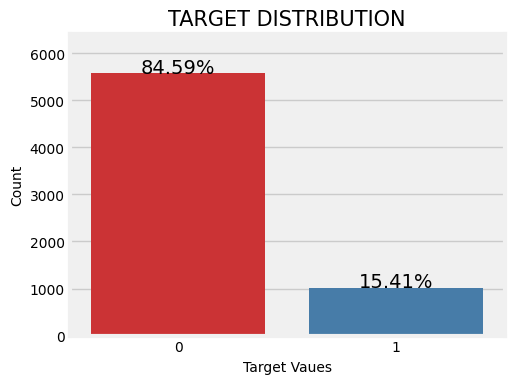

In [7]:
total = len(df)
plt.figure(figsize=(5,4), dpi=100)

g = sns.countplot(x= 'class', data=df, palette='Set1')
g.set_title("TARGET DISTRIBUTION", fontsize = 15)
g.set_xlabel("Target Vaues", fontsize = 10)
g.set_ylabel("Count", fontsize = 10)
sizes=[] # Get highest values in y
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
g.set_ylim(0, max(sizes) * 1.15) # set y limit based on highest heights

plt.show()

Target distribution is highly imbalanced. Accuracy metric is not useful here it will mislead the result. So, we've to look into F1 score for model evalution.

## # specifing the features and target variables.

In [8]:
target_cols = ['class']

feature_cols = [col for col in df.columns if col.startswith('f')]

## Distribution Of Data

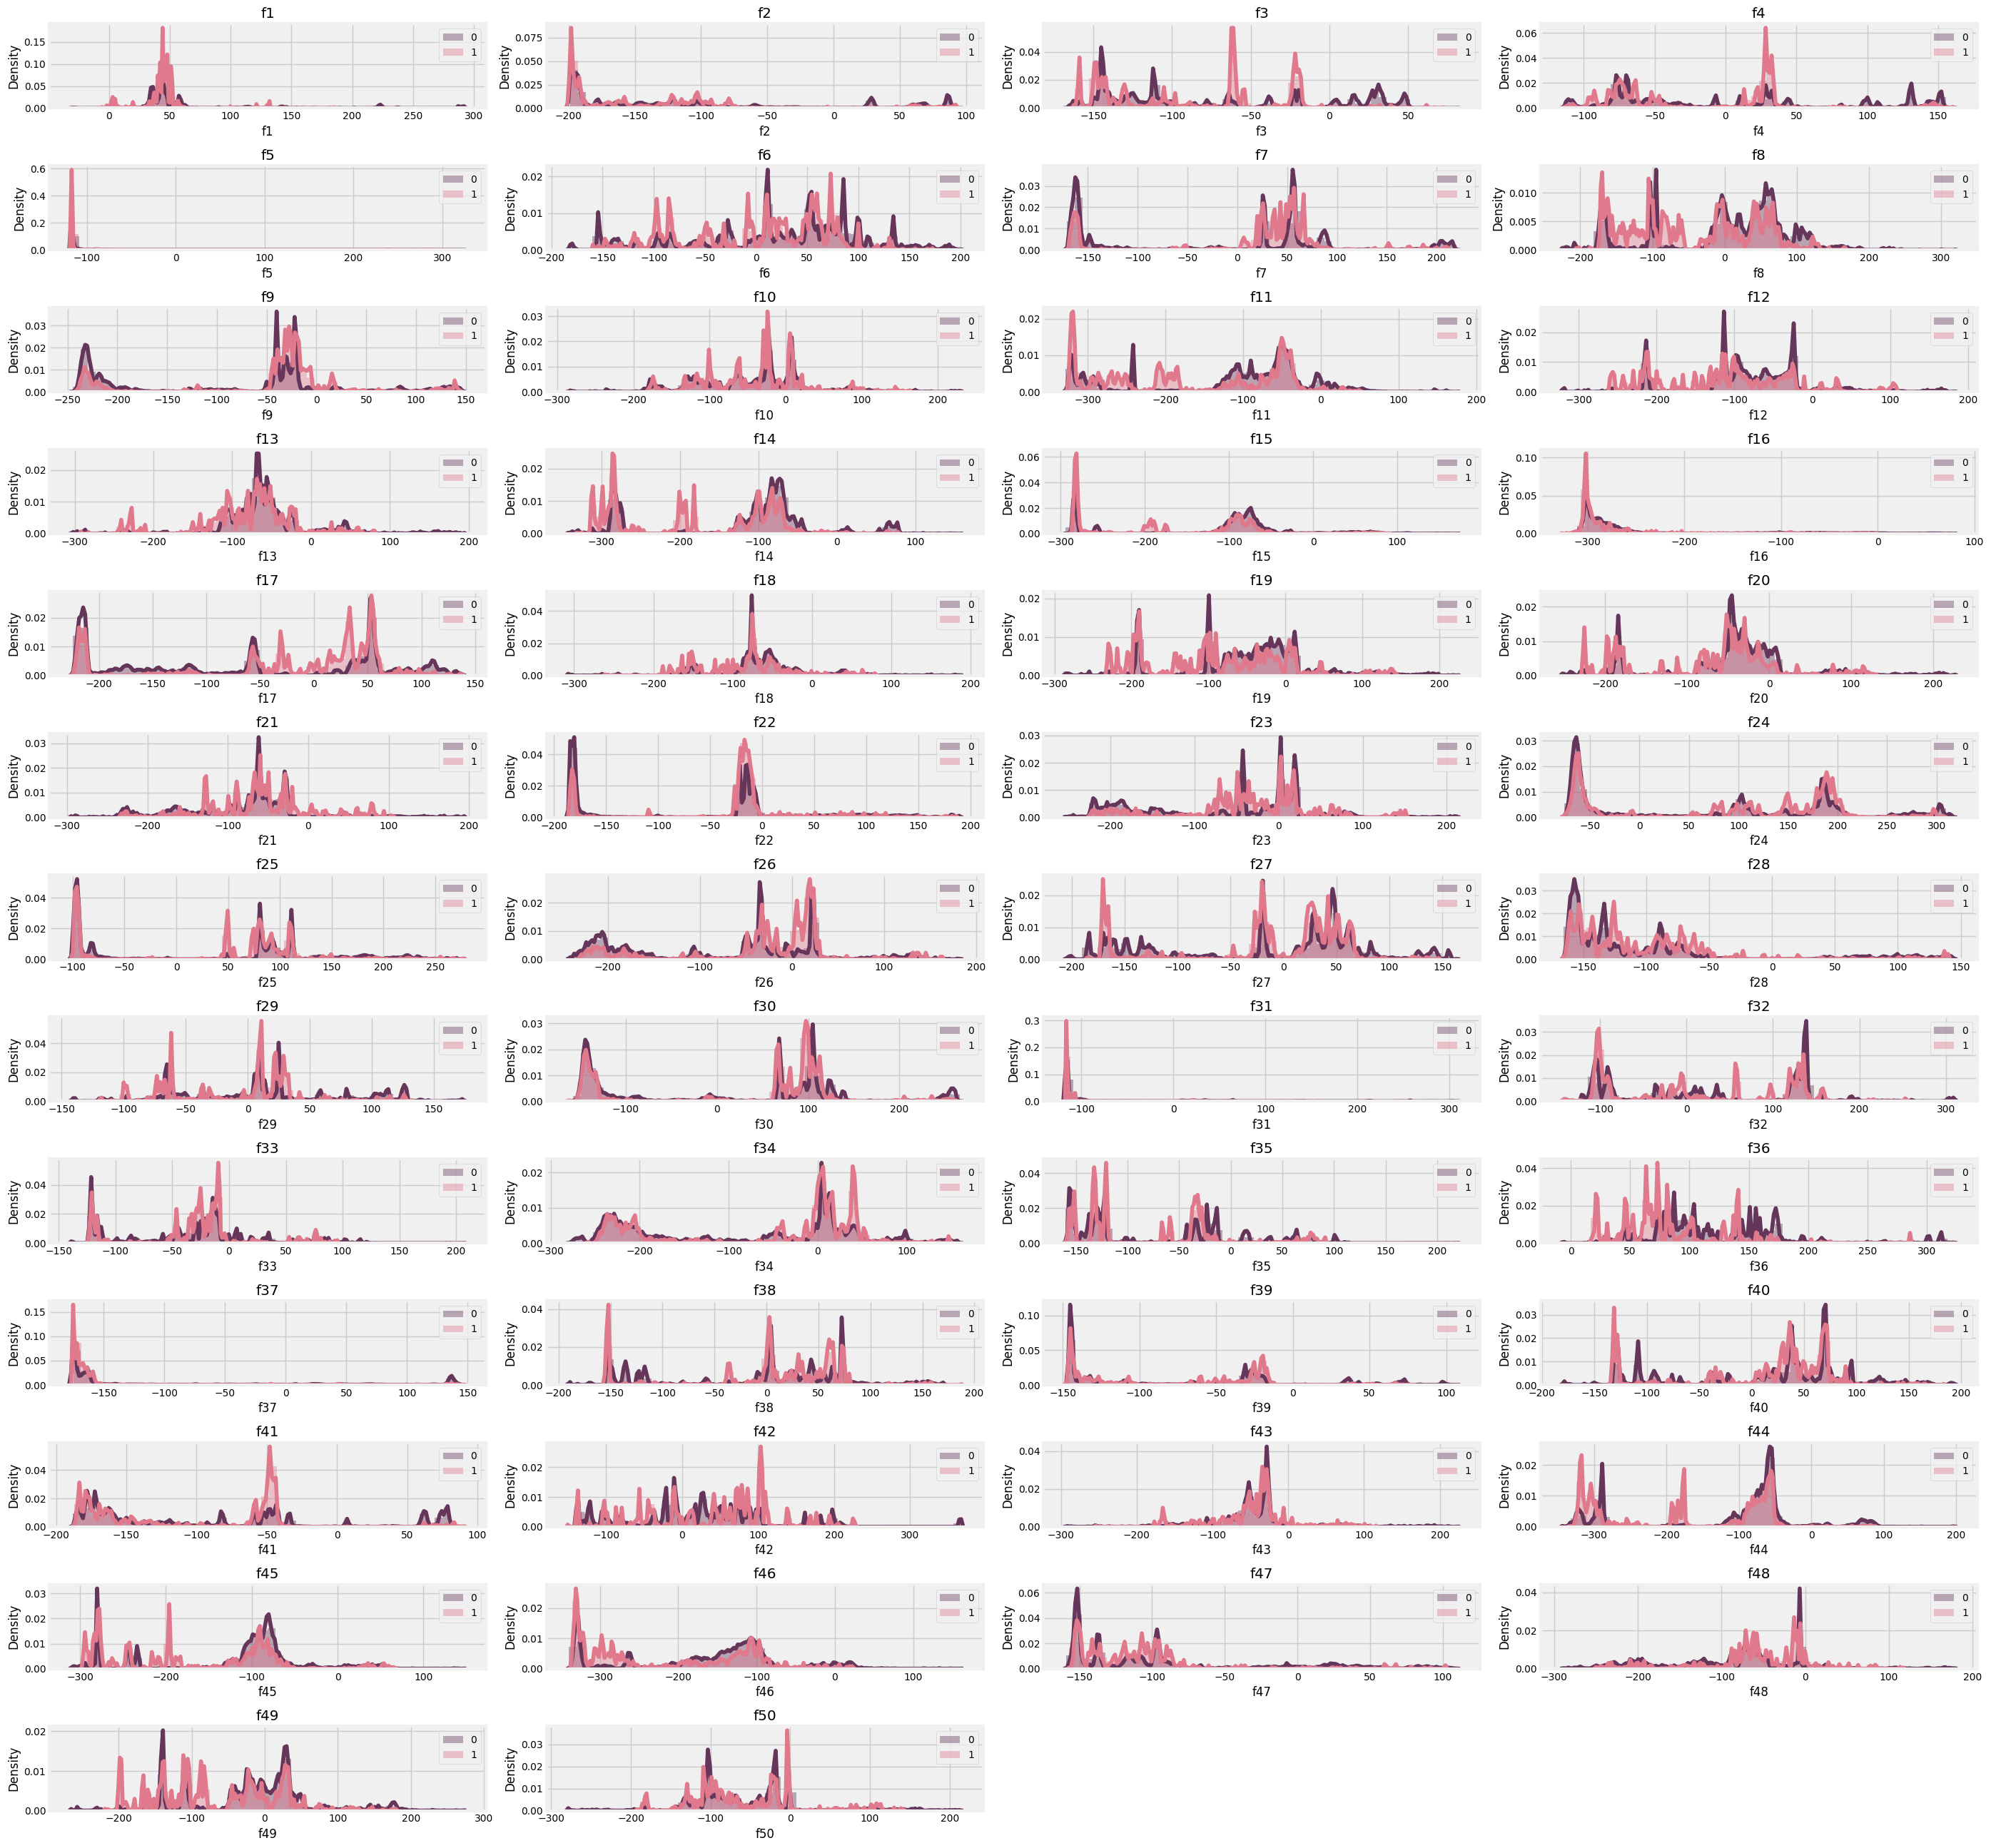

In [9]:
# Distributions of Nuberical Variable First 50 Columns By Target
plt.figure(figsize=(28, 26), dpi=100)
t0 = df.loc[df['class'] == 0]
t1 = df.loc[df['class'] == 1]
for i, col in enumerate(list(feature_cols)[:50]):
    plt.subplot(13, 4, i + 1)
    sns.distplot(t0[col],  kde=True, bins=50, color=colors_nude[1], label='0', kde_kws={'bw':0.01})
    sns.distplot(t1[col],  kde=True, bins=50, color=colors_nude[0], label='1', kde_kws={'bw':0.01})
    plt.title(col)
    plt.legend()
    plt.tight_layout()

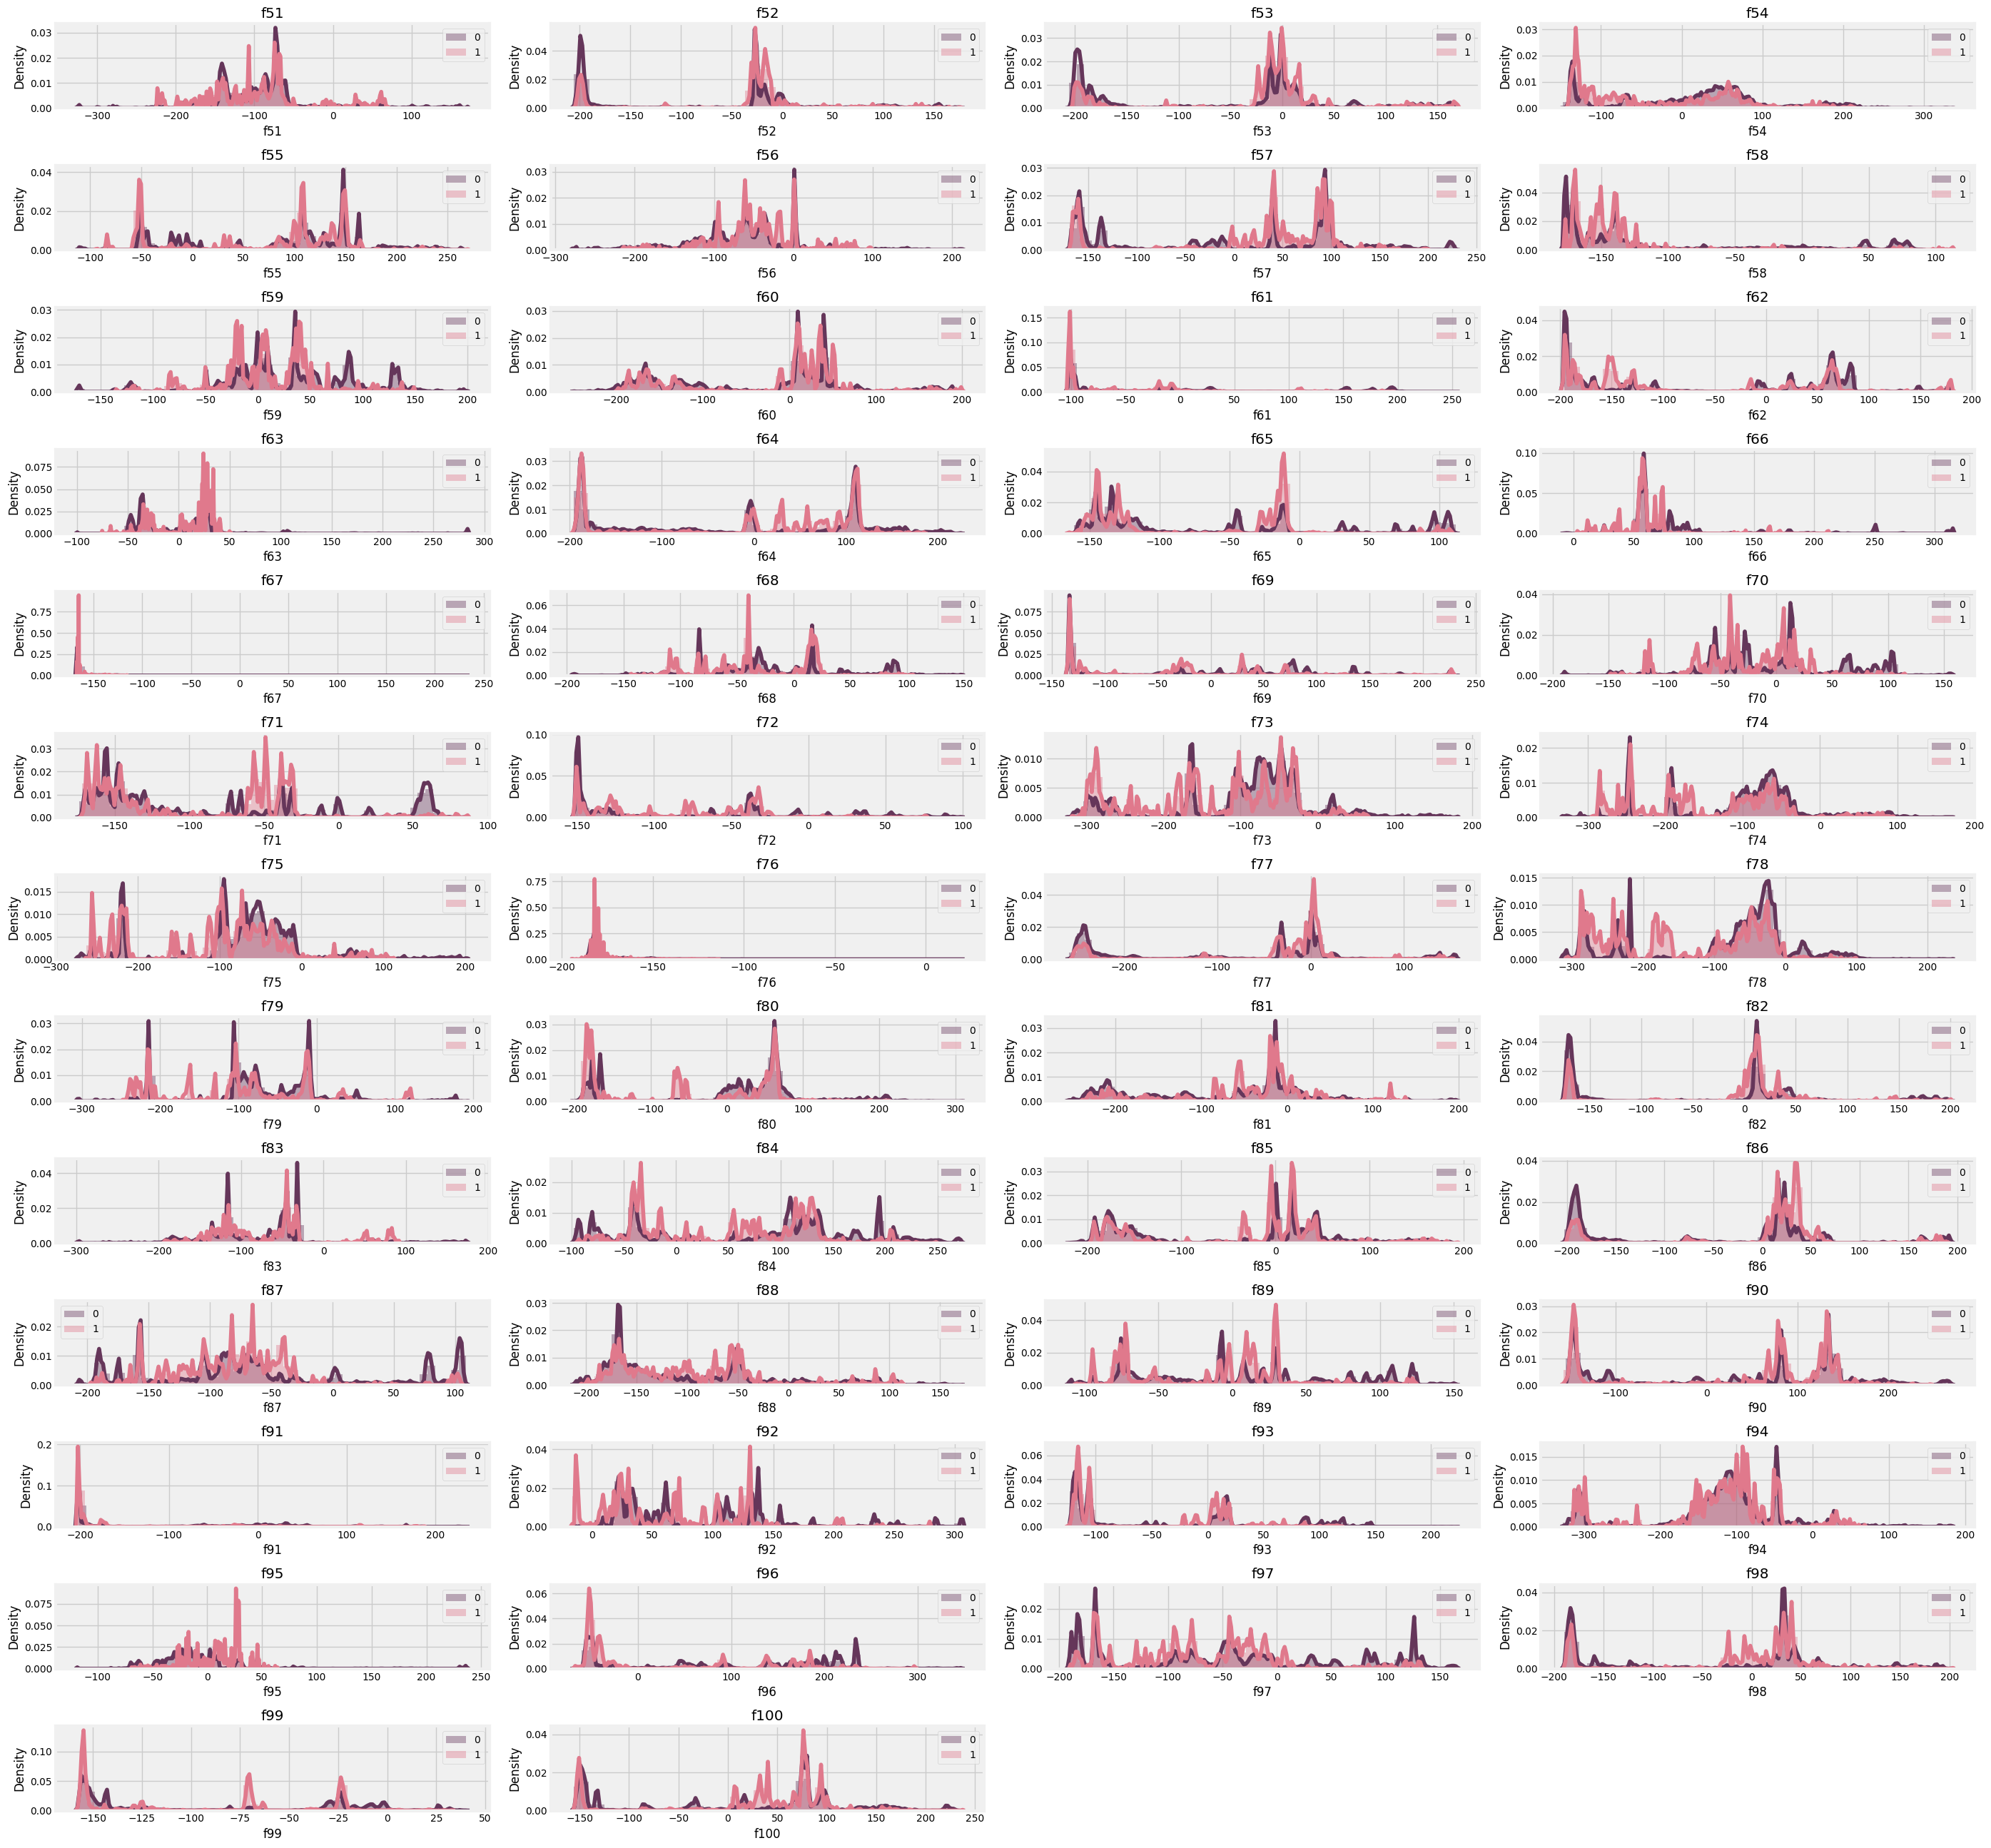

In [10]:
# Distributions of Nuberical Variable next 50 Columns By Target
plt.figure(figsize=(28, 26), dpi=100)
t0 = df.loc[df['class'] == 0]
t1 = df.loc[df['class'] == 1]
for i, col in enumerate(list(feature_cols)[50:100]):
    plt.subplot(13, 4, i + 1)
    sns.distplot(t0[col],  kde=True, bins=50, color=colors_nude[1], label='0', kde_kws={'bw':0.01})
    sns.distplot(t1[col],  kde=True, bins=50, color=colors_nude[0], label='1', kde_kws={'bw':0.01})
    plt.title(col)
    plt.legend()
    plt.tight_layout()

* Data is right skewed or positive skewed
* Data contain outliear

# Preprocssing
## Quantile Transformation

In [11]:
for col in feature_cols:

    transformer = preprocessing.QuantileTransformer(n_quantiles=100,random_state=0, output_distribution="normal")
    vec_len = len(df[col].values)
    raw_vec = df[col].values.reshape(vec_len, 1)
    transformer.fit(raw_vec)

    df[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]

In [12]:
df[feature_cols].shape

(6598, 166)

## PCA Feature added

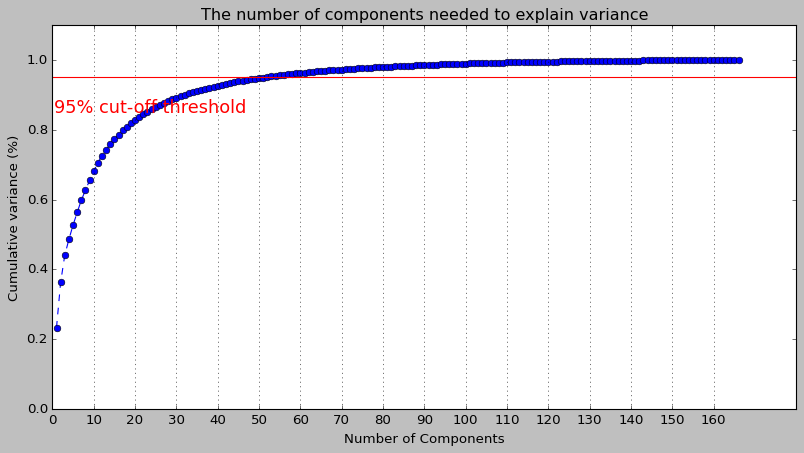

In [13]:
plt.style.use('classic')
pca = PCA().fit(df[feature_cols])

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 167, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 170, step=10)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

### To get 95% of variance explained I need 60 principal components.

In [14]:
n_comp = 60

pca_data = (PCA(n_components=n_comp, random_state=42).fit_transform(df[feature_cols]))

pca_data = pd.DataFrame(pca_data, columns=[f'pca_f{i}' for i in range(n_comp)])

df = pd.concat((df, pca_data), axis=1)

## Feature Selection

In [15]:
## including pca feature and existing feature
feature_cols = [col for col in df.columns if col.startswith(('f','pca'))]

from sklearn.feature_selection import VarianceThreshold

var_thresh = VarianceThreshold(threshold=0.5)
final_feature = var_thresh.fit_transform(df[feature_cols])
final_feature_df =pd.concat([pd.DataFrame(final_feature), df[target_cols]],  axis=1)

## Train Test split

In [16]:
#Let's split the train and test 
train = final_feature_df.iloc[:, :-2]
target = final_feature_df[['class']]

X_train, X_test, y_train, y_test = train_test_split(train, 
                                                    target, 
                                                    test_size = 0.20, 
                                                    random_state=44, 
                                                    stratify=target)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5278, 205), (1320, 205), (5278, 1), (1320, 1))

## Config

In [17]:
EPOCHS = 30
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
dropout= 0.25

## Model and Training

In [24]:
x_train=X_train.values.reshape(X_train.shape[0],41,5,1)
x_test=X_test.values.reshape(X_test.shape[0],41,5,1)

model=tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(41,5,1)))
model.add(tf.keras.layers.Conv2D(64,(2,2),activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.Adam(lr = LEARNING_RATE), loss='binary_crossentropy', metrics=["accuracy"])

result = model.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(x_test,y_test))

Epoch 1/30
42/42 [==============================] - 1s 30ms/step - loss: 0.3758 - accuracy: 0.8526 - val_loss: 0.2961 - val_accuracy: 0.8614
Epoch 2/30
42/42 [==============================] - 1s 28ms/step - loss: 0.2498 - accuracy: 0.8990 - val_loss: 0.1860 - val_accuracy: 0.9258
Epoch 3/30
42/42 [==============================] - 1s 28ms/step - loss: 0.1821 - accuracy: 0.9312 - val_loss: 0.1387 - val_accuracy: 0.9485
Epoch 4/30
42/42 [==============================] - 1s 26ms/step - loss: 0.1443 - accuracy: 0.9485 - val_loss: 0.1194 - val_accuracy: 0.9644
Epoch 5/30
42/42 [==============================] - 1s 25ms/step - loss: 0.1183 - accuracy: 0.9540 - val_loss: 0.1057 - val_accuracy: 0.9659
Epoch 6/30
42/42 [==============================] - 1s 27ms/step - loss: 0.1093 - accuracy: 0.9549 - val_loss: 0.0893 - val_accuracy: 0.9735
Epoch 7/30
42/42 [==============================] - 1s 27ms/step - loss: 0.0969 - accuracy: 0.9610 - val_loss: 0.0844 - val_accuracy: 0.9765
Epoch 8/30
42

## PLOT results

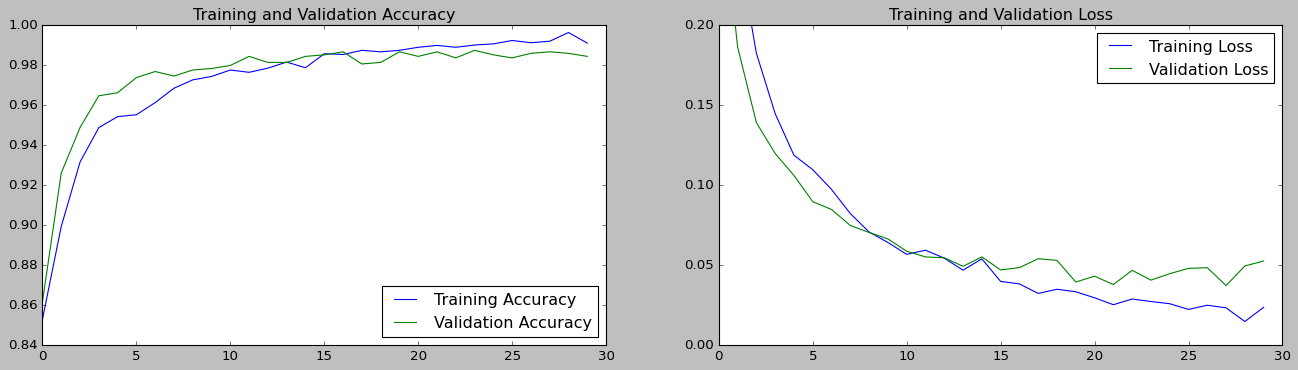

In [25]:
# fetch results from history
acc = result.history['accuracy']
val_acc = result.history['val_accuracy']

loss = result.history['loss']
val_loss = result.history['val_loss']

epochs_range = range(EPOCHS)

# create subplots
plt.figure(figsize = (20,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
# limit y-values for beter zoom-scale
#plt.ylim(0.05, 0.4) 
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
# limit y-values for beter zoom-scale
plt.ylim(0, 0.2) 
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
# predict test_data
print("Predicting Test...")
pred = model.predict_classes(x_test)

Predicting Test...


In [27]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test.values, pred))
print('\n')
print(classification_report(y_test.values, pred))

[[1116    1]
 [  20  183]]


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1117
           1       0.99      0.90      0.95       203

    accuracy                           0.98      1320
   macro avg       0.99      0.95      0.97      1320
weighted avg       0.98      0.98      0.98      1320



In [28]:
print("Accuracy:", metrics.accuracy_score(y_test.values, pred))
print("Precision score:", metrics.precision_score(y_test.values, pred))
print("Recall score:", metrics.recall_score(y_test.values, pred))
print("F1_score:", metrics.f1_score(y_test.values, pred))

Accuracy: 0.9840909090909091
Precision score: 0.9945652173913043
Recall score: 0.9014778325123153
F1_score: 0.9457364341085271


# Detailed Report

### Pre-processing
* Cheching the nan values in data.
* In eda we can see the data is skew, to improve data distribution I applied  QuantileTransformer.
* Principal component analysis (PCA) is used for dimension reduction. it transforms your original feature set into a smaller set of weighted linear combinations. This set of weighted linear combinations are your principal components which retain the information from your original dataset.
* And VarianceThreshold used for feature selection.
### Model 
* This is a 4 layers Squential Neural Network for Musk dataset. I choosed to build it with keras API (Tensorflow backend) which is very intuitive.

* 'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

* Dropout is a regularization method,his drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

* I choosed Adam to perform optimization and is one of the best optimizer at present. Adam is an adaptive learning rate method.

* The metric function "accuracy" is used is to evaluate the performance our model. 

### Evaluation
* The model reaches almost 98 % accuracy with f1_score of 94 %. The validation accuracy is greater than the training accuracy almost every time during the training. That means that our model dosen't not overfit the training set.
Our model is very well trained !!!

* Let's see the classification report, we can see that NN model performs very well with Precision (Accuracy of positive predictions) of class 0 and 1 is 0.98 and 0.99 respectively. 
